# Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.oc_pipeline import EstimationPipeline

## Configuration

In [2]:
data_name = "DS03"

In [3]:
# Paths
experiment_dir = Path('experiments')/data_name
opcond_dir = experiment_dir/'opcond'
data_split = 'dev'

## 1. Load dataset

In [4]:
df = pd.read_csv(experiment_dir/f'data_{data_split}.csv',dtype={"Fc": str})

## Load the pipeline

In [5]:
pipe:EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
pipe.set_bounds(df,q_low=0.01, q_high=0.99)
df_hi = pipe.transform(df)

## Apply pipeline

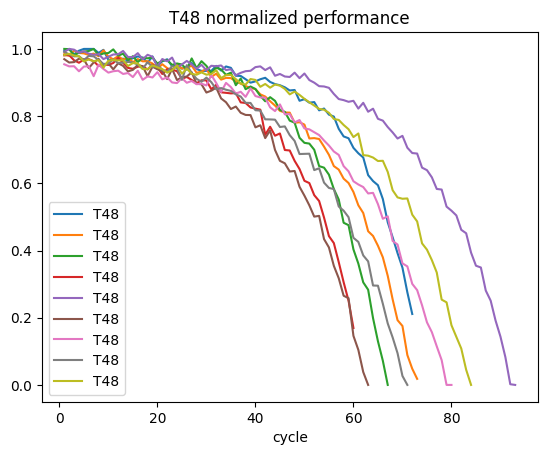

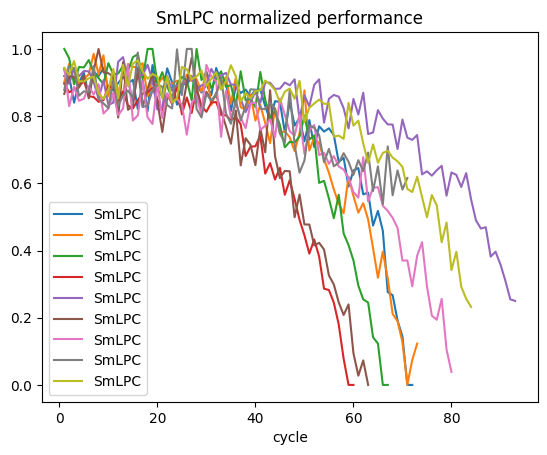

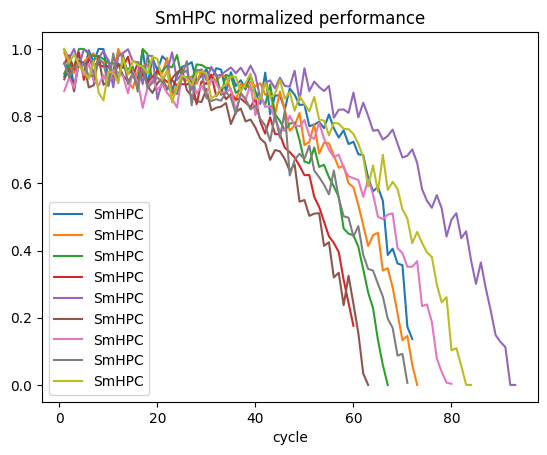

In [10]:
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} normalized performance")
    df_hi.groupby("unit").plot(x="cycle", y=f'{perf}', ax=ax, legend=True)

## Save hi data

In [7]:
df_hi = df_hi[['unit']+['cycle']+ pipe.get_performances()]

In [8]:
df_hi

,unit,cycle,T48,SmLPC,SmHPC
0,1.0,1.0,0.993711,0.919042,0.917439
1,1.0,2.0,1.000000,0.917661,0.975871
2,1.0,3.0,0.984046,0.840029,0.885552
3,1.0,4.0,0.994716,0.899406,0.963047
4,1.0,5.0,1.000000,0.928985,0.925791
...,...,...,...,...,...
658,9.0,80.0,0.177643,0.341759,0.103302
659,9.0,81.0,0.142913,0.396250,0.109271
660,9.0,82.0,0.108302,0.292205,0.056929
661,9.0,83.0,0.045158,0.256773,0.000000


In [9]:
df_hi.to_csv(experiment_dir/f'hidata_{data_split}.csv', index=False)